In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

import tensorflow as tf
print(tf.__version__)

import autoencoder
import model
import json
import requests
from datetime import datetime
from datetime import timedelta
sns.set()

1.15.2


In [2]:
r = requests.get('https://api.alternative.me/fng/?limit=1500')
data = json.loads(r.text)

df_fearGreed = pd.DataFrame(data["data"], columns=["timestamp", "value"]).rename(columns={"timestamp": "DATE", "value": "Fear&Greed"})
df_fearGreed["DATE"] = pd.to_datetime(df_fearGreed["DATE"], unit="s")
df_fearGreed["Fear&Greed"] = df_fearGreed["Fear&Greed"].astype(float)
df_fearGreed = df_fearGreed.set_index("DATE")

In [3]:
start = datetime(2018, 2, 1)
end = datetime(2020, 10, 11)
Indicators = DataReader(["CBBTCUSD", "CBBCHUSD", "CBCCIND", "CBETHUSD", "sp500", "VIXCLS", "T10YIE", "DGS5", "GOLDPMGBD230NLBM", "SLVPRUSD"], 'fred', start, end)\
    .fillna(method="pad").fillna(method="backfill").join(df_fearGreed).fillna(50)

In [5]:
Indicators.to_csv('dataset/Indicators.csv', index=True, header=True)

In [4]:
Indicators = pd.read_csv('dataset/Indicators.csv', index_col="DATE")

In [4]:
Indicators

,CBBTCUSD,CBBCHUSD,CBCCIND,CBETHUSD,sp500,VIXCLS,T10YIE,DGS5,GOLDPMGBD230NLBM,SLVPRUSD,Fear&Greed
DATE,,,,,,,,,,,
2018-02-01,9014.23,1254.86,4512.850019,1017.48,2821.98,13.47,2.11,2.56,1078.58,17.190,30.0
2018-02-02,8787.52,1181.00,4455.297470,911.99,2762.13,17.31,2.14,2.58,1071.18,17.135,15.0
2018-02-03,9240.00,1269.71,4655.899898,969.40,2762.13,17.31,2.14,2.58,1071.18,17.135,40.0
2018-02-04,8167.91,1156.16,4168.798254,826.00,2762.13,17.31,2.14,2.58,1071.18,17.135,24.0
2018-02-05,6905.19,880.00,3520.919532,693.54,2648.94,37.32,2.10,2.50,1075.01,16.875,11.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-07,10671.23,223.36,3180.272971,342.15,3419.45,28.06,1.71,0.35,1601.83,23.530,43.0
2020-10-08,10926.71,233.99,3180.272971,350.49,3446.83,26.36,1.72,0.33,1607.73,23.960,46.0
2020-10-09,11059.30,237.14,3180.272971,365.23,3477.13,25.00,1.73,0.33,1628.99,24.315,48.0


In [7]:
ROC = True

Indicators_pct = Indicators.pct_change()
date_ori = pd.to_datetime(Indicators_pct.index).tolist()

if ROC:
    Indicators_sca = Indicators.copy()
    Indicators_full = pd.concat([Indicators_sca, Indicators_pct], axis=1)

    minmax = MinMaxScaler().fit(Indicators_full.iloc[:, 0].values.reshape((-1,1)))
    scaler = MinMaxScaler().fit(Indicators_full)
    Indicators_full[:] = scaler.transform(Indicators_full)
else:
    minmax = MinMaxScaler().fit(Indicators.iloc[:, 0].values.reshape((-1,1)))
    scaler = MinMaxScaler().fit(Indicators)
    Indicators_full = Indicators.copy()
    Indicators_full[:] = scaler.transform(Indicators)

In [8]:
df_log = Indicators_full[1:]
df_log

,CBBTCUSD,CBBCHUSD,CBCCIND,CBETHUSD,sp500,VIXCLS,T10YIE,DGS5,GOLDPMGBD230NLBM,SLVPRUSD,...,CBBCHUSD,CBCCIND,CBETHUSD,sp500,VIXCLS,T10YIE,DGS5,GOLDPMGBD230NLBM,SLVPRUSD,Fear&Greed
DATE,,,,,,,,,,,,,,,,,,,,,
2018-02-02,0.576625,0.660487,0.767465,0.887114,0.390587,0.089922,0.976190,0.824138,0.078403,0.303910,...,0.409857,0.650246,0.508232,0.461613,0.373324,0.347308,0.459720,0.413060,0.612125,0.040210
2018-02-03,0.623179,0.713522,0.813643,0.948549,0.390587,0.089922,0.976190,0.824138,0.078403,0.303910,...,0.547670,0.748540,0.766999,0.560872,0.168189,0.328205,0.448052,0.477503,0.623338,0.381119
2018-02-04,0.512876,0.645636,0.701513,0.795095,0.390587,0.089922,0.976190,0.824138,0.078403,0.303910,...,0.378410,0.493959,0.439515,0.560872,0.168189,0.328205,0.448052,0.477503,0.623338,0.055944
2018-02-05,0.382960,0.480534,0.552373,0.653347,0.306333,0.368458,0.952381,0.796552,0.083653,0.288507,...,0.224697,0.407552,0.420202,0.369083,1.000000,0.303091,0.401742,0.511087,0.570162,0.033654
2018-02-06,0.463548,0.533151,0.624580,0.749968,0.340722,0.266286,0.952381,0.803448,0.089987,0.284360,...,0.573281,0.823500,0.871416,0.642498,0.026666,0.328205,0.460000,0.517870,0.608801,0.075969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.872773,0.118225,0.473957,0.376455,0.940057,0.216592,0.773810,0.031034,0.868228,0.909064,...,0.451894,0.671942,0.688843,0.550599,0.276313,0.350978,0.448052,0.477503,0.623338,0.118881
2020-09-01,0.898063,0.129441,0.473957,0.420715,0.959663,0.212556,0.750000,0.024138,0.873903,1.000000,...,0.540838,0.671942,0.816968,0.596090,0.160288,0.298348,0.341373,0.501109,0.820024,0.118881
2020-09-02,0.844396,0.112378,0.473957,0.381592,1.000000,0.218820,0.732143,0.024138,0.865678,0.930095,...,0.370116,0.671942,0.549999,0.632787,0.180586,0.305303,0.448052,0.443377,0.480174,0.135664


In [12]:
thought_vector = autoencoder.reducedimension(df_log.values, 6, 0.001, 128, 1000)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


epoch: 10 loss: 0.29638305 time: 0.0017158985137939453
epoch: 20 loss: 0.29620442 time: 0.0016932487487792969
epoch: 30 loss: 0.2959003 time: 0.0017049312591552734
epoch: 40 loss: 0.2953803 time: 0.002496957778930664
epoch: 50 loss: 0.29448545 time: 0.0017237663269042969
epoch: 60 loss: 0.29292804 time: 0.0017011165618896484
epoch: 70 loss: 0.2901665 time: 0.0017459392547607422
epoch: 80 loss: 0.28513402 time: 0.0017268657684326172
epoch: 90 loss: 0.2758434 time: 0.0017011165618896484
epoch: 100 loss: 0.26086426 time: 0.0016589164733886719
epoch: 110 loss: 0.24539776 time: 0.0017430782318115234
epoch: 120 loss: 0.23438907 time: 0.0020470619201660156
epoch: 130 loss: 0.22006938 time: 0.0022318363189697266
epoch: 140 loss: 0.19573052 time: 0.001706838607788086
epoch: 150 los

In [18]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 1000
dropout_rate = 0.5

In [20]:
tf.reset_default_graph()
modelnn = model.Model(0.01, num_layers, thought_vector.shape[1], size_layer, 1, dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0)
        batch_y = df_log.values[k + 1: k + timestamp + 1, 0].reshape([-1, 1])
        last_state, _, loss = sess.run([modelnn.last_state, 
                                        modelnn.optimizer, 
                                        modelnn.cost], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y, 
                                                                  modelnn.hidden_layer: init_value})
        init_value = last_state
        total_loss += loss
    total_loss /= (thought_vector.shape[0] // timestamp)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.007650173226338861
epoch: 200 avg loss: 0.005653369177678307
epoch: 300 avg loss: 0.005611861725096836
epoch: 400 avg loss: 0.0035226123574673652
epoch: 500 avg loss: 0.0031911661557074617
epoch: 600 avg loss: 0.003139555380555741
epoch: 700 avg loss: 0.41207488095738315
epoch: 800 avg loss: 0.027528704228360013
epoch: 900 avg loss: 0.03313394525289906
epoch: 1000 avg loss: 0.006573567265189022


In [34]:
boundary = (thought_vector.shape[0] // timestamp) * timestamp
predict_days = len(df_log) - boundary

output_predict = np.zeros(((thought_vector.shape[0] // timestamp) * timestamp, 1))
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[k: k + timestamp, :] = out_logits
    
out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(thought_vector[-predict_days:, :], axis = 0),
                                  modelnn.hidden_layer: init_value})
init_value = last_state
output_predict_last = out_logits

In [35]:
print('Mean Square Error:', np.mean(np.square(output_predict[:, 0] - df_log.iloc[1: (thought_vector.shape[0] // timestamp) * timestamp + 1, 0].values)))

Mean Square Error: 0.010203540522361193


In [36]:
import statsmodels.api as sm
from itertools import product
from scipy import stats
    
Qs = range(0, 1)
qs = range(0, 2)
Ps = range(0, 2)
ps = range(0, 2)
D=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
best_aic = float("inf")
for param in parameters_list:
#     try:
    arima=sm.tsa.statespace.SARIMAX(df_log.iloc[:,0].values, order=(param[0], D, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#     except:
#         continue
    aic = arima.aic
    if aic < best_aic and aic:
        best_arima = arima
        best_aic = aic
        
best_aic

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-3285.0018330078683

In [37]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

In [1]:
last =10

pred_arima = best_arima.predict()
pred_arima_last = pred_arima[-predict_days:]
x_range = np.arange(df_log.shape[0])[-last:]
fig = plt.figure(figsize = (15,6))
ax = plt.subplot(111)
ax.plot(x_range, reverse_close(df_log.iloc[:,0].values)[-last:], label = 'true Close')
ax.plot(x_range, reverse_close(pred_arima)[-last:], label = 'predict Close using Arima')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.xticks(x_range[::5], date_ori[::5][-last:])
plt.title('overlap market Close')
plt.show()

NameError: name 'best_arima' is not defined

In [39]:
stack_predict = np.vstack([pred_arima[:boundary], output_predict.reshape((-1))]).T
stack_predict_last = np.vstack([pred_arima_last, output_predict_last.reshape((-1))]).T

In [40]:
where_below_0 = np.where(stack_predict < 0)
where_higher_1 = np.where(stack_predict > 1)
stack_predict[where_below_0[0], where_below_0[1]] = 0
stack_predict[where_higher_1[0], where_higher_1[1]] = 1

where_below_0_last = np.where(stack_predict_last < 0)
where_higher_1_last = np.where(stack_predict_last > 1)
stack_predict_last[where_below_0_last[0], where_below_0_last[1]] = 0
stack_predict_last[where_higher_1_last[0], where_higher_1_last[1]] = 1

In [41]:
corr_df = pd.DataFrame(np.hstack([stack_predict, df_log.values[:boundary, 0].reshape((-1,1))]))

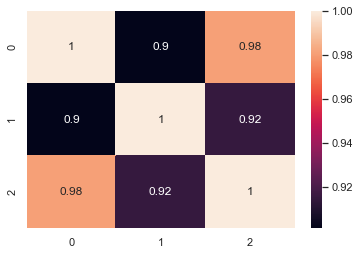

In [42]:
sns.heatmap(corr_df.corr(), annot= True)
plt.show()

In [ ]:
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = df_log.values[:boundary, 0]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict,train_Y, eval_set=[(stack_predict,train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

In [ ]:
stacked = clf.predict(stack_predict)
stacked_last = clf.predict(stack_predict_last)

In [ ]:
last =20

plt.figure(figsize = (15,6))
x_range = np.arange(boundary)[-last:]
plt.plot(x_range, reverse_close(train_Y)[-last:], label = 'Real Close')
plt.plot(x_range, reverse_close(pred_arima[:boundary])[-last:], label = 'ARIMA Close')
plt.plot(x_range, reverse_close(output_predict)[-last:], label = 'RNN Close')
plt.plot(x_range, reverse_close(stacked)[-last:], label = 'Stacked Close')
plt.legend()
plt.xticks(x_range[::5], date_ori[:boundary][-last:][::5])
plt.title('stacked RNN + ARIMA with XG B')
plt.show()

In [ ]:
plt.figure(figsize = (15,6))
x_range = np.arange(5)
plt.xticks(x_range, date_ori[-predict_days:])
plt.plot(x_range, reverse_close(df_log.iloc[-predict_days:,0].values), label = 'Real Close')
plt.plot(x_range, reverse_close(pred_arima_last), label = 'ARIMA Close')
plt.plot(x_range, reverse_close(output_predict_last), label = 'RNN Close')
plt.plot(x_range, reverse_close(stacked_last), label = 'Stacked Close')
plt.legend()
plt.title('Final prediction')
plt.show()